# Training GNS on the 2D Taylor Green Vortex
This tutorial notebook will show how to train a GNS model on the 2D Taylor Green Vortex. It will give a brief overview of LagrangeBench on these topics:
- Datasets and case setup
- Models
- Training tricks and strategies (random-walk noise and pushforward)
- Training and inference

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import lagrangebench
import haiku as hk
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.animation as animation

2023-10-22 00:45:53.519258: W external/xla/xla/service/gpu/nvptx_compiler.cc:673] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Datasets
First thing to do is to load the dataset. The simplest way to do this is by using the `lagrangebench.data.TGV2D` class. It will automatically download the HDF5 files if they are not found in the respective folder, and it will take care of setting up the dataset. Note that for the validation set `is_rollout=True`. This means that the dataset will not split the trajectory into subsequences and keep whole rollouts for evaluation.

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
tgv2d_train = lagrangebench.data.TGV2D("train")
tgv2d_eval = lagrangebench.data.TGV2D("valid", is_rollout=True)

print(
    f"This is a {tgv2d_train.metadata['dim']}D dataset "
    f"called {tgv2d_train.metadata['case']}.\n"
    f"Train snapshot have shape {tgv2d_train[0][0].shape} (n_nodes, seq_len, xy pos).\n"
    f"Val snapshot have shape {tgv2d_eval[0][0].shape} (n_nodes, rollout, xy pos).\n"
)

Retrieving folder list


Processing file 1b0SFiLGz273cxA8uVg001q6yY_67Mid2 metadata.json
Processing file 1a249Qy5YUohxV9fhMrCM9b_sO6CfujYa test.h5
Processing file 1tPM513kE3ob__HBMmj4pvRaD766kOvAz train.h5
Processing file 1x5GyDN-1oFeYFSnzcLK2ahXIxr0cMZnl valid.h5
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1b0SFiLGz273cxA8uVg001q6yY_67Mid2
To: /home/harish/Desktop/lagrangebench/notebooks/datasets/2D_TGV_2500_10kevery100/metadata.json
100%|██████████| 1.04k/1.04k [00:00<00:00, 7.94MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1a249Qy5YUohxV9fhMrCM9b_sO6CfujYa
From (redirected): https://drive.google.com/uc?id=1a249Qy5YUohxV9fhMrCM9b_sO6CfujYa&confirm=t&uuid=ce3ce8cd-9411-44ba-8f6d-a0e8956ab620
To: /home/harish/Desktop/lagrangebench/notebooks/datasets/2D_TGV_2500_10kevery100/test.h5
100%|██████████| 114M/114M [00:05<00:00, 20.8MB/s] 
Downloading...
From (uriginal): https://drive.google.com/uc?id=1tPM513kE3ob__HBMmj4pvRaD766kOvAz
From (redirected): https://drive.google.com/uc?id=1tPM513kE3ob__HBMmj4pvRaD766kOvAz&confirm=t&uuid=c79ecab9-b215-43b6-8683-cc908df11635
To: /home/harish/Desktop/lagrangebench/notebooks/datasets/2D_TGV_2500_10kevery100/train.h5
100%

This is a 2D dataset called TGV.
Train snapshot have shape (2500, 7, 2) (n_nodes, seq_len, xy pos).
Val snapshot have shape (2500, 126, 2) (n_nodes, rollout, xy pos).



Similarly, for other datasets one can use the respective subclass, for example
```python
rpf_3d_data = lagrangebench.data.RPF3D("train") # 3D Reverse Poiseuille Flow
dam_2d_data = lagrangebench.data.DAM2D("train") # 2D Dam break
# etc.
# and in general: 
lagrangebench.data.H5Dataset("train", dataset_path="path/to/dataset")
```

## Models
All models should inherit from [`models.BaseModel`](/lagrangebench/models/base.py), and generally include a `_transform` function for feature engineering and graph building. 

Here we use a small GNS model, with 16 latent dimension and 4 message passing layers and predicting 2D accelerations. Note that we use a function wrapper beause `haiku.Modules` must be initialized inside `haiku.transform`.


In [4]:
def gns(x):
    return lagrangebench.GNS(
        particle_dimension=tgv2d_train.metadata["dim"],
        latent_size=16,
        blocks_per_step=2,
        num_mp_steps=4,
        particle_type_embedding_size=8,
    )(x)

Then apply `haiku.transform` to the model function

In [5]:
gns = hk.without_apply_rng(hk.transform_with_state(gns))

## Training tricks and strategies
To improve performance and stabilize training we can use a number of tricks and strategies. In this notebook we will cover random-walk noise and pushforward, which are included by default in LagrangeBench. 

### Random-walk noise
Briefly, random-walk noise adds noise to the velocities in the input sequence and adjusts the target positions accordingly. The standard deviation is passed as a parameter, and each noise step is rescaled so that the cumulated noise has the input standard deviation. It applied to GNNs in physics in the ["Learning to Simulate Complex Physics with Graph Networks"](https://arxiv.org/abs/2002.09405) paper (2020).

### Pushforward
Instead of training always on the next step, the pushforward trick will randomly sample a number of "unroll" steps to perform and compute the loss only on the last one. Ideally this should inject the "right amount" of noise, since it comes from the physical distribution. Because it adds some overhead, the maximum number of unroll steps should not be too large and the probability of unrolling large sequences should be reasonably small. It comes from the ["Message Passing Neural PDE Solvers"](https://arxiv.org/pdf/2202.03376.pdf) paper (2022).

In [6]:
noise_std = 1e-5

pf_config = lagrangebench.PushforwardConfig(
    steps=[-1, 5000, 10000],  # training steps to unlock the relative stage
    unrolls=[0, 2, 5],  # number of unroll steps per stage
    probs=[7, 2, 1],  # probabilities to unroll to the relative stage
)

For example, this configuration would apply noise with `std=1e-5` and the pushforward trick with three unroll stages (0, 2 and 5), "unlocking" the second stage after 5000 training steps and the third stage after 10000 training steps. After 10000 steps, 0-step unroll (normal training) will happen with a probability of 70%, 2-step unroll with a probability of 20% and finally 5-step unroll with a probability of 10%.

## Case
The `CaseSetupFn` is an essential part in LagrangeBench. Most of the operations during training, such as data preprocessing, time integration for the ouput and neighbor computation are managed by `CaseSetupFn`. The easies way to initialize it is through the `lagrangebench.case_builder` function.

In [7]:
bounds = np.array(tgv2d_train.metadata["bounds"])
box = bounds[:, 1] - bounds[:, 0]

tgv2d_case = lagrangebench.case_builder(
    box=box,  # (x,y) array with the world size along each axis. (1.0, 1.0) for 2D TGV
    metadata=tgv2d_train.metadata,  # metadata dictionary
    input_seq_length=6,  # number of consecutive time steps fed to the model
    isotropic_norm=False,  # whether to normalize each dimension independently
    noise_std=noise_std,  # noise standard deviation used by the random-walk noise
)

## Training and inference
Finally, to train GNS on Taylor Green (with noise and pushforward) the `lagrangebench.Trainer` methods comes to hand

In [8]:
trainer = lagrangebench.Trainer(
    model=gns,
    case=tgv2d_case,
    data_train=tgv2d_train,
    data_eval=tgv2d_eval,
    pushforward=pf_config,
    noise_std=noise_std,
    metrics=["mse"],
    n_rollout_steps=20,
    eval_n_trajs=1,
    lr_start=5e-4,
    log_steps=1000,
    eval_steps=5000,
)

params, state, _ = trainer(step_max=25000)

00000, train/loss: 1.41751.
01000, train/loss: 0.00331.
02000, train/loss: 0.15835.
03000, train/loss: 0.00123.
04000, train/loss: 0.19778.
05000, train/loss: 1.62274.
{'val/loss': 0.0020771375857293606, 'val/mse1': 1.7247542700715712e-06, 'val/mse5': 3.6240595363778993e-05, 'val/mse10': 0.00024540332378819585, 'val/stdloss': 0.0, 'val/stdmse1': 0.0, 'val/stdmse5': 0.0, 'val/stdmse10': 0.0}
06000, train/loss: 0.02041.
07000, train/loss: 0.01039.
08000, train/loss: 0.01020.
09000, train/loss: 1.18557.
10000, train/loss: 0.06333.
{'val/loss': 0.0014516240917146206, 'val/mse1': 1.6560027233936125e-06, 'val/mse5': 3.3121523301815614e-05, 'val/mse10': 0.0002024288260145113, 'val/stdloss': 0.0, 'val/stdmse1': 0.0, 'val/stdmse5': 0.0, 'val/stdmse10': 0.0}
Reallocate neighbors list (2, 20965) at step 10125
To list (2, 20875)
Reallocate neighbors list (2, 20875) at step 10140
To list (2, 20772)
Reallocate neighbors list (2, 20772) at step 10387
To list (2, 20797)
Reallocate neighbors list (2, 2

Now let's see what the trained GNS can do. First, let's get the test data. As for the validation set, `is_rollout=True` so that the dataset does not split the trajectory into subsequences.

In [9]:
tgv2d_test = lagrangebench.TGV2D("test", is_rollout=True)

Then let's run then evaluation over 20 timesteps. Here we use three evaluation metrics: __position MSE__ and __Sinkhorn__ distance.

In [10]:
metrics = lagrangebench.infer(
    gns,
    tgv2d_case,
    tgv2d_test,
    params,
    state,
    metrics=["mse", "sinkhorn"],
    eval_n_trajs=1,
    n_rollout_steps=20,
    rollout_dir="rollouts/",
    out_type="pkl",
)["rollout_0"]
rollout = pickle.load(open("rollouts/rollout_0.pkl", "rb"))

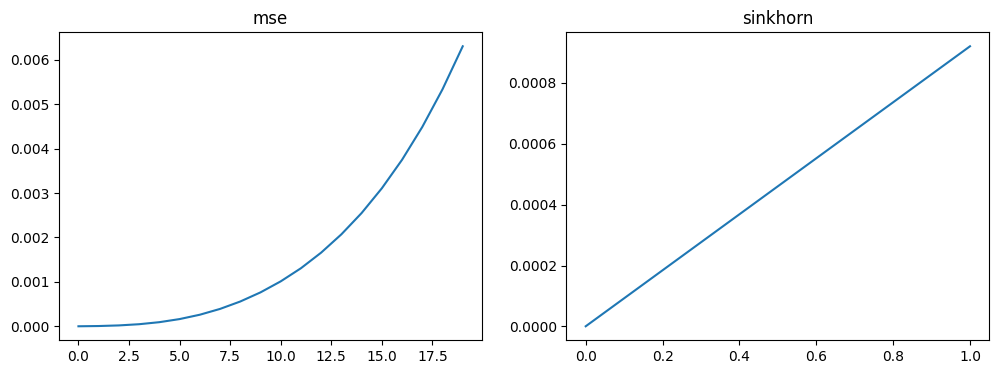

In [11]:
# plot metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot the metrics
for i, m in enumerate(["mse", "sinkhorn"]):
    ax[i].plot(metrics[m])
    ax[i].set_title(m)

In [12]:
print(f"rollout of shape {rollout['predicted_rollout'].shape} (steps, nodes, xy pos)")

fig, ax = plt.subplots(1, 2)
ax[0].set_xlim([0, 1.0])
ax[0].set_ylim([0, 1.0])
ax[1].set_xlim([0, 1.0])
ax[1].set_ylim([0, 1.0])
fig.set_size_inches(10, 5, forward=True)
ax[0].set_title("GNS")
ax[1].set_title("Ground Truth")

rollout_len = rollout["predicted_rollout"].shape[0] - 1

scat0 = ax[0].scatter(
    rollout["predicted_rollout"][0, :, 0], rollout["predicted_rollout"][0, :, 1]
)
scat1 = ax[1].scatter(
    rollout["ground_truth_rollout"][0, :, 0], rollout["ground_truth_rollout"][0, :, 1]
)


def animate(i):
    scat0.set_offsets(rollout["predicted_rollout"][i])
    scat1.set_offsets(rollout["ground_truth_rollout"][i])
    return scat0, scat1


ani = animation.FuncAnimation(
    fig, animate, repeat=True, frames=rollout_len, interval=50
)

plt.close(fig)

writer = animation.PillowWriter(fps=10, metadata=dict(artist="Me"), bitrate=1800)
ani.save("media/scatter.gif", writer=writer)

from IPython.display import Image

Image(url="media/scatter.gif")

rollout of shape (26, 2500, 2) (steps, nodes, xy pos)
